In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv("/kaggle/input/text-dataset/training.csv")
test_data=pd.read_csv("/kaggle/input/text-dataset/test.csv")
val_data=pd.read_csv("/kaggle/input/text-dataset/validation.csv")

In [3]:
train_data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
from collections import Counter 
Counter(train_data['label'])

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})

In [5]:
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
index = train_data[train_data['text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
train_data.shape

(15969, 2)

In [6]:
def lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    tqdm.pandas()
    df.text=df.text.progress_apply(lambda text : lower_case(text))
    df.text=df.text.progress_apply(lambda text : remove_stop_words(text))
    df.text=df.text.progress_apply(lambda text : Removing_numbers(text))
    df.text=df.text.progress_apply(lambda text : Removing_punctuations(text))
    df.text=df.text.progress_apply(lambda text : Removing_urls(text))
    df.text=df.text.progress_apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [7]:
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from nltk.stem import SnowballStemmer
import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


In [8]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)
val_data= normalize_text(val_data)

100%|██████████| 2000/2000 [00:12<00:00, 162.59it/s]


In [9]:
X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [10]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

2024-06-08 14:41:41.427537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 14:41:41.427651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 14:41:41.541975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
tokenizer.document_count

17969

In [12]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [13]:
maxlen = max([len(t) for t in train_data['text']])
maxlen

221

In [14]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 12931


In [15]:
path_to_glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [16]:
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 11799 words (1131 misses)


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [18]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [19]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))
model.build(input_shape=(None, X_train.shape[1]))
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 229, 200)       │     2,586,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 229, 512)       │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 229, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,574,302 (17.45 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 2,586,200 (9.87 MB)

In [20]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.4151 - loss: 1.4866 - val_accuracy: 0.7440 - val_loss: 0.7111
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7796 - loss: 0.6269 - val_accuracy: 0.8785 - val_loss: 0.3519
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8789 - loss: 0.3358 - val_accuracy: 0.8990 - val_loss: 0.2700
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9129 - loss: 0.2305 - val_accuracy: 0.9165 - val_loss: 0.2036
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9277 - loss: 0.1745 - val_accuracy: 0.9185 - val_loss: 0.1884
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9417 - loss: 0.1339 - val_accuracy: 0.9150 - val_loss: 0.2094
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9425 - loss: 0.1351 - val_accuracy: 0.9195 - val_loss: 0.1993
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9436 - loss: 0.1305 - val_accuracy: 0.9210 - val_los

In [21]:
model.save("final_model.keras")

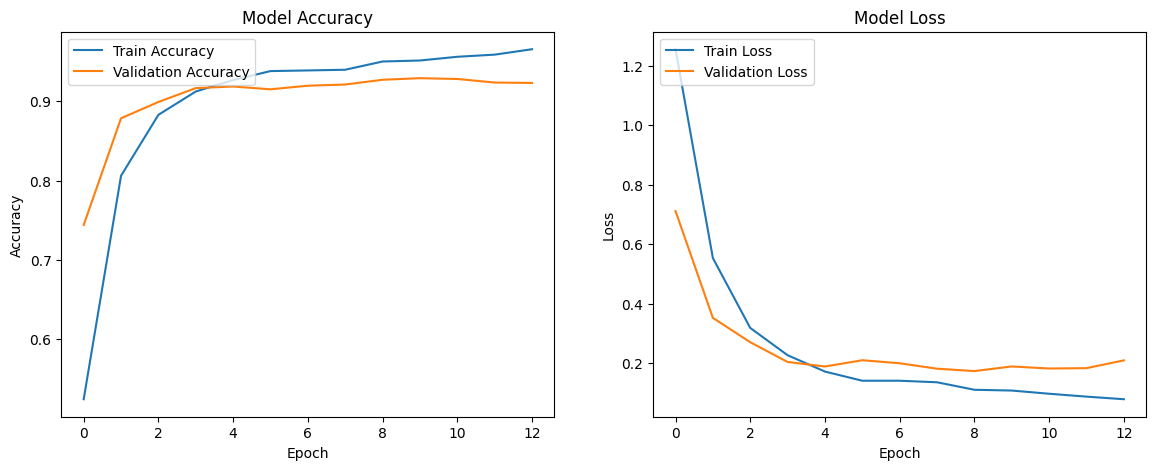

In [22]:
import matplotlib.pyplot as plt

# Assuming the model has been trained and the history object is available
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    # Show the plots
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)


In [23]:
pred=np.argmax(model.predict(X_test),axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step


In [24]:
from sklearn.metrics import accuracy_score,classification_report
print("accuracy of model on test dataset is ",accuracy_score(pred,y_test))


accuracy of model on test dataset is  0.91


In [25]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       586
           1       0.93      0.93      0.93       691
           2       0.75      0.82      0.78       146
           3       0.89      0.94      0.91       260
           4       0.89      0.87      0.88       230
           5       0.88      0.67      0.76        87

    accuracy                           0.91      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [26]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!",
            "i lost my friend",
            "Dogs are sitting by the door."
            ]
emotion_dict = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = np.argmax(model.predict(sentence), axis=1)
    print(f"{result} : {emotion_dict[result[0]]}\n\n")

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
[1] : joy


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
[3] : anger


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[0] : sadness


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
[5] : surprise


i lost my friend
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
[0] : sadness


Dogs are sitting by the door.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
[4] : fear




In [27]:
import json

# Serialize the tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# Save the JSON to a file
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

In [28]:
!pip install SpeechRecognition


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 50.5 MB/s eta 0:00:00:00:0100:01


In [29]:
import speech_recognition as sr

# Initialize the recognizer
r = sr.Recognizer()

# Audio file path
AUDIO_FILE = "/kaggle/input/indian-emotional-speech-corpora-iesc/Indian Emotional Speech Corpora (IESC)/Speaker-4/Anger/A-1-4-1.wav"

# Load audio file
with sr.AudioFile(AUDIO_FILE) as source:
    # Record the audio data
    audio_data = r.record(source)
    
    try:
        print("Recognizing speech...")
        # Use Google Speech Recognition
        text = r.recognize_google(audio_data)
        print("Speech recognized:")
        print(text)
    except sr.UnknownValueError:
        print("Could not understand audio")
    except sr.RequestError as e:
        print("Error accessing Google Speech Recognition service; {0}".format(e))


Recognizing speech...
Speech recognized:
kids are talking by the door


In [30]:
sentences=["kids are talking by the door"]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = np.argmax(model.predict(sentence), axis=1)
    print(f"{result} : {emotion_dict[result[0]]}\n\n")

kids are talking by the door
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
[4] : fear


